In [1]:
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import torch
import numpy as np
from importlib import reload
import random
from random import shuffle

import rl4pm_lib.preprocessing as preprocessing
reload(preprocessing)
from IPython import display

In [2]:
test_df = pd.read_csv('datasets/test_df.csv').drop(columns='Unnamed: 0')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

train_df = pd.read_csv('datasets/train_df.csv').drop(columns='Unnamed: 0')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: datetime.datetime.fromisoformat(x))

### Propro like for SklEarn

In [3]:
import rl4pm_lib.preprocessing as preprocessing

column_feature = {'tt': 0, 'te': 1, 'tw': 2}
prepro = preprocessing.DfPreprocesser()
prepro.fit(train_df)
train_df_pr = prepro.transform(train_df)
test_df_pr = prepro.transform(test_df)

In [4]:
scaler = preprocessing.PaperScaler(column_feature)
scaler.fit(train_df_pr)
train_df_pr_sc = scaler.transform(train_df_pr)
test_df_pr_sc = scaler.transform(test_df_pr)

## Ok let's create data loader & dataset

In [5]:
from rl4pm_lib.lstm_supervised import ProcessesDataset

In [6]:
win_len = 2
batch_size = 512
n_lstm = 1
m_lstm = 2
hidden_layer = 128
n_epoch = 100
n_classes = len(set(train_df['activity'].values))

In [7]:
test_ds = ProcessesDataset(test_df_pr_sc, win_len)
train_ds = ProcessesDataset(train_df_pr_sc, win_len)

In [8]:
test_ds[0]['data'].shape

torch.Size([137, 54])

In [9]:
test_ds.df_win.columns

Index(['tt', 'te', 'tw', 'trace_id', 'A_ACCEPTED', 'A_ACTIVATED', 'A_APPROVED',
       'A_CANCELLED', 'A_DECLINED', 'A_FINALIZED', 'A_PARTLYSUBMITTED',
       'A_PREACCEPTED', 'A_REGISTERED', 'A_SUBMITTED', 'O_ACCEPTED',
       'O_CANCELLED', 'O_CREATED', 'O_DECLINED', 'O_SELECTED', 'O_SENT',
       'O_SENT_BACK', 'W_Afhandelen leads', 'W_Beoordelen fraude',
       'W_Completeren aanvraag', 'W_Nabellen incomplete dossiers',
       'W_Nabellen offertes', 'W_Valideren aanvraag',
       'W_Wijzigen contractgegevens', 'tt__1', 'te__1', 'tw__1',
       'A_ACCEPTED__1', 'A_ACTIVATED__1', 'A_APPROVED__1', 'A_CANCELLED__1',
       'A_DECLINED__1', 'A_FINALIZED__1', 'A_PARTLYSUBMITTED__1',
       'A_PREACCEPTED__1', 'A_REGISTERED__1', 'A_SUBMITTED__1',
       'O_ACCEPTED__1', 'O_CANCELLED__1', 'O_CREATED__1', 'O_DECLINED__1',
       'O_SELECTED__1', 'O_SENT__1', 'O_SENT_BACK__1', 'W_Afhandelen leads__1',
       'W_Beoordelen fraude__1', 'W_Completeren aanvraag__1',
       'W_Nabellen incomplete

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### Modles init

In [12]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_layer, n_lstm, m_lstm, n_classes, dropout=0.05):
        super(Net, self).__init__()
        if n_lstm > 0:
            self.bb_lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_layer,
                                         num_layers=n_lstm)
            self.ac_lstm = torch.nn.LSTM(input_size=hidden_layer, hidden_size=hidden_layer,
                                         num_layers=m_lstm)
            self.te_lstm = torch.nn.LSTM(input_size=hidden_layer, hidden_size=hidden_layer,
                                         num_layers=m_lstm)
        else:
            self.ac_lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_layer,
                                         num_layers=m_lstm)
            self.te_lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_layer,
                                         num_layers=m_lstm)
            
        
        self.relu = torch.nn.ReLU()
        self.fc_ac = torch.nn.Linear(hidden_layer, n_classes)
        self.fc_te = torch.nn.Linear(hidden_layer, 1)
        
        self.n_classes = n_classes
        self.n_lstm = n_lstm
        self.m_lstm = m_lstm
        self.hidden = hidden_layer
        
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        if self.n_lstm > 0:
            # back bone lstm
            x, h = self.bb_lstm(x)
            x = self.dropout(x)
            x = self.relu(x)
            if self.n_lstm == self.m_lstm:
                h = (self.dropout(h[0]), self.dropout(h[1]))
                # head for action and t_e
                x_ac, _ = self.ac_lstm(x, h)
                x_te, _ = self.te_lstm(x, h)
            else:
                x_ac, _ = self.ac_lstm(x)
                x_te, _ = self.te_lstm(x)
        else:
            # head for action and t_e
            x_ac, _ = self.ac_lstm(x)
            x_te, _ = self.te_lstm(x)
            

        x_te = self.relu(x_te)
        x_te = self.relu(x_te)
        
        x_ac = self.fc_ac(x_ac)
        x_te = self.fc_te(x_te)
        
        x_te = self.relu(x_te)
        x_ac = torch.nn.functional.softmax(x_ac, dim=-1)
        return x_te, x_ac

In [17]:
input_size = test_ds.tensor_data.shape[-1]

model = Net(input_size=input_size, hidden_layer=hidden_layer, n_lstm=n_lstm,
            m_lstm=m_lstm, n_classes=n_classes).to(device)

### Optimizers and losses

In [18]:
loss_ac = torch.nn.CrossEntropyLoss()

loss_te = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
from rl4pm_lib.lstm_supervised import train_one_epoch, for_evaluate
from rl4pm_lib.utils import get_accuracy, get_f1_score, get_log_loss, get_mae_days, plot_learning

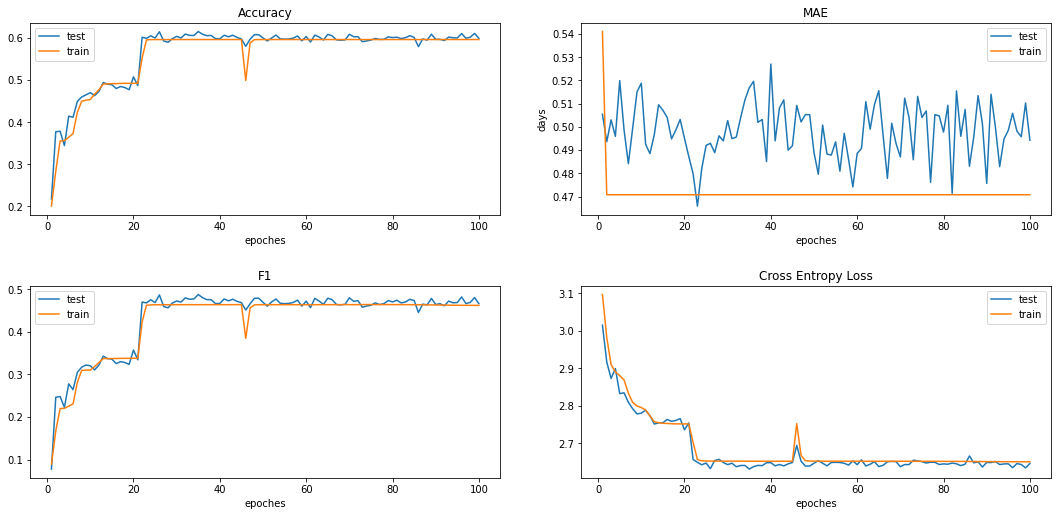

In [20]:
train_acc = []
test_acc = []

train_mae = []
test_mae = []

test_ce = []
train_ce = []

test_f1 = []
train_f1 = []

epoches = []

for ep in range(n_epoch):
    train_acc
    train_data = train_one_epoch(dataloader=train_dataloader, device=device,
                       model=model, optimizer=optimizer,
                       loss_ac=loss_ac, loss_te=loss_te, n_classes=n_classes)
    
    eval_data = for_evaluate(test_dataloader, model, n_classes=n_classes, device=device)
    
    epoches.append(ep+1)
    
    test_acc.append(get_accuracy(true=eval_data['true_label'],
                                 pred=eval_data['pred_label']))
    train_acc.append(get_accuracy(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    test_mae.append(get_mae_days(true=eval_data['true_tes'],
                                 pred=eval_data['pred_tes'], scaler=scaler))
    train_mae.append(get_mae_days(true=train_data['true_tes'],
                                  pred=train_data['pred_tes'], scaler=scaler))
    
    test_ce.append(get_log_loss(true=eval_data['true_label'],
                                     pred=eval_data['pred_label']))
    train_ce.append(get_log_loss(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    test_f1.append(get_f1_score(true=eval_data['true_label'],
                                 pred=eval_data['pred_label']))
    train_f1.append(get_f1_score(true=train_data['true_label'],
                                  pred=train_data['pred_label']))
    
    display.clear_output(wait=True)
    plot_learning(test_acc=test_acc, train_acc=train_acc,
                  test_mae=test_mae, train_mae=train_mae,
                  test_f1=test_f1, train_f1=train_f1,
                  test_ce=test_ce, train_ce=train_ce,
                  epoches=epoches
                  )

In [ ]:
t = torch.tensor([1., 2., 3.])

In [ ]:
t.data